In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install scikit-learn  -U
!pip install ray[tune] tune-sklearn

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import time
from sklearn.dummy import DummyClassifier
from sklearn import model_selection #train_test_split, cross_validate, GridSearchCV
from sklearn import neural_network #MLP
from sklearn import preprocessing #StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, precision_recall_fscore_support,f1_score
from sklearn.svm import SVC
from sklearn import decomposition #PCA
from sklearn import feature_selection #VCA
from imblearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.linear_model import SGDClassifier

from ray.tune.sklearn import TuneGridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     |████████████████████████████████| 23.2 MB 440 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.3 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0.1 which is incompatible.
     |████████████████████████████████| 40 kB 653 kB/s 
/kaggle/input/csgo-round-winner-classification/csgo_round_snapshots.csv


### Enable autocompletion

In [2]:
 %config Completer.use_jedi = False

### Data Processing

First, find what the data folder contains.

In [3]:
ls ../input/csgo-round-winner-classification

csgo_round_snapshots.csv


In [4]:
df = pd.read_csv('/kaggle/input/csgo-round-winner-classification/csgo_round_snapshots.csv')
data = df.to_numpy()
print("The Dataset contains", df.shape[0], "samples and", df.shape[1], "features.\n")
print(df.head())

The Dataset contains 122410 samples and 97 features.

   time_left  ct_score  t_score       map  bomb_planted  ct_health  t_health  \
0     175.00       0.0      0.0  de_dust2         False      500.0     500.0   
1     156.03       0.0      0.0  de_dust2         False      500.0     500.0   
2      96.03       0.0      0.0  de_dust2         False      391.0     400.0   
3      76.03       0.0      0.0  de_dust2         False      391.0     400.0   
4     174.97       1.0      0.0  de_dust2         False      500.0     500.0   

   ct_armor  t_armor  ct_money  ...  t_grenade_flashbang  \
0       0.0      0.0    4000.0  ...                  0.0   
1     400.0    300.0     600.0  ...                  0.0   
2     294.0    200.0     750.0  ...                  0.0   
3     294.0    200.0     750.0  ...                  0.0   
4     192.0      0.0   18350.0  ...                  0.0   

   ct_grenade_smokegrenade  t_grenade_smokegrenade  \
0                      0.0                     0.0

### Missing Values

Three ways:

In [5]:
df.isnull().sum()

time_left                    0
ct_score                     0
t_score                      0
map                          0
bomb_planted                 0
                            ..
ct_grenade_molotovgrenade    0
t_grenade_molotovgrenade     0
ct_grenade_decoygrenade      0
t_grenade_decoygrenade       0
round_winner                 0
Length: 97, dtype: int64

In [6]:
cat '/kaggle/input/csgo-round-winner-classification/csgo_round_snapshots.csv' | grep "?" | wc -l

0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     122410 non-null  float64
 1   ct_score                      122410 non-null  float64
 2   t_score                       122410 non-null  float64
 3   map                           122410 non-null  object 
 4   bomb_planted                  122410 non-null  bool   
 5   ct_health                     122410 non-null  float64
 6   t_health                      122410 non-null  float64
 7   ct_armor                      122410 non-null  float64
 8   t_armor                       122410 non-null  float64
 9   ct_money                      122410 non-null  float64
 10  t_money                       122410 non-null  float64
 11  ct_helmets                    122410 non-null  float64
 12  t_helmets                     122410 non-nul

As we can see, our dataset is perfect; there are no missing values.

### Balance Inspection

In [8]:
labels = data[:,-1]
feats  = data[:,:-1]

In [9]:
np_labels = np.array(labels)
print(np_labels)
print(feats.shape)
print(len(np_labels[np_labels=='CT']),"matches are won by the CT and",len(np_labels[np_labels=='T']),"are won by the Terrorists.")
print("The balance of the Dataset is",round(len(np_labels[np_labels=='T'])/len(labels),2),"in favor of the Terrorist team.")

['CT' 'CT' 'CT' ... 'T' 'T' 'T']
(122410, 96)
60004 matches are won by the CT and 62406 are won by the Terrorists.
The balance of the Dataset is 0.51 in favor of the Terrorist team.


Our dataset is balanced too. Talk about luck, huh!

### Singular Values

If we find a column that contains only one value, we drop it.

In [10]:
for column in df.columns:
    if len(df[column].unique())==1:
        print(f'Dropping column {column}.')
        df = df.drop([column], axis=1)

Dropping column ct_weapon_bizon.
Dropping column ct_weapon_g3sg1.
Dropping column t_weapon_m249.
Dropping column ct_weapon_negev.
Dropping column ct_weapon_r8revolver.
Dropping column ct_weapon_sawedoff.


The dropped columns are the weapons that no one has bought in any of the competitive games.
We now check that the columns are indeed dropped.

In [11]:
len(df.columns)

91

## Data Splitting

In [12]:
# Alter df[map]'s type from string to int.
encoder = preprocessing.LabelEncoder()
df['map'] = encoder.fit_transform(df['map'])

In [13]:
y = df['round_winner']
X = df.drop('round_winner', axis=1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.8, random_state=0)

#or
#x_train,x_test,y_train,y_test = model_selection.train_test_split(feats,labels,test_size=0.2,random_state=42)

## Classification

We created this function to train some Dummy Classifiers and use them as a baseline for the MLP and SVM classifiers.

In [14]:
def DummyClassification(x_train,y_train,x_test,y_test):
    
    scores, predictions, fit_times, pred_times = {}, {}, {}, {}

    ### Initialization ###
    
    dc_uniform  = DummyClassifier(strategy="uniform")
    dc_const_CT = DummyClassifier(strategy="constant",constant='CT')
    dc_const_T = DummyClassifier(strategy="constant",constant='T')
    dc_stratified = DummyClassifier(strategy="stratified")
    dc_frequent = DummyClassifier(strategy="most_frequent")

    ### Fit ###
    
    start_time = time.time()
    dc_uniform.fit(x_train, y_train)
    fit_times['uniform'] = time.time()-start_time
    
    start_time = time.time()
    dc_const_CT.fit(x_train, y_train)
    fit_times['const_CT'] = time.time()-start_time
    
    start_time = time.time()
    dc_const_T.fit(x_train, y_train)
    fit_times['const_T'] = time.time()-start_time
    
    start_time = time.time()
    dc_stratified.fit(x_train, y_train)
    fit_times['stratified'] = time.time()-start_time
    
    start_time = time.time()
    dc_frequent.fit(x_train,y_train)
    fit_times['frequent'] = time.time()-start_time
    
    ### Predict ###
    
    start_time = time.time()
    predictions['uniform']  = dc_uniform.predict(x_test)
    pred_times['uniform'] = time.time()-start_time
    
    start_time = time.time()
    predictions['const_CT']  = dc_const_CT.predict(x_test)
    pred_times['const_CT'] = time.time()-start_time
    
    start_time = time.time()
    predictions['const_T']  = dc_const_T.predict(x_test)
    pred_times['const_T'] = time.time()-start_time
    
    start_time = time.time()
    predictions['stratified']  = dc_stratified.predict(x_test)
    pred_times['stratified'] = time.time()-start_time
    
    start_time = time.time()
    predictions['frequent'] = dc_frequent.predict(x_test)
    pred_times['frequent'] = time.time()-start_time

    ### Score ###
    
    scores['uniform']  = dc_uniform.score(x_test, y_test)
    scores['const_CT']  = dc_const_CT.score(x_test, y_test)
    scores['const_T']  = dc_const_T.score(x_test, y_test)
    scores['stratified']  = dc_stratified.score(x_test, y_test)
    scores['frequent'] = dc_frequent.score(x_test,y_test)
    
    return predictions, scores, fit_times, pred_times

## Out of The Box

### **Dummy**

In [15]:
predictions, accuracies, _, _ = DummyClassification(X_train, y_train, X_test, y_test)

print("Confusion Matrices of the Dummy Classifier: \n")
for strategy in predictions:
    print(f'For strategy -> {strategy}:\n {confusion_matrix(y_test, predictions[strategy])}')

print("\nF1 Score of the Dummy Classifier: \n")
for strategy in predictions:
    print(f'For strategy -> {strategy}:')
    print(f'\tMicro: {f1_score(y_test, predictions[strategy], average = "micro")}')
    print(f'\tMacro: {f1_score(y_test, predictions[strategy], average = "macro")}\n')

print("\nAccuracy of the Dummy Classifier: \n")
for strategy in accuracies:
    print(f'For strategy -> {strategy}: {accuracies[strategy]}')

Confusion Matrices of the Dummy Classifier: 

For strategy -> uniform:
 [[5876 6069]
 [6244 6293]]
For strategy -> const_CT:
 [[11945     0]
 [12537     0]]
For strategy -> const_T:
 [[    0 11945]
 [    0 12537]]
For strategy -> stratified:
 [[5874 6071]
 [6204 6333]]
For strategy -> frequent:
 [[    0 11945]
 [    0 12537]]

F1 Score of the Dummy Classifier: 

For strategy -> uniform:
	Micro: 0.49705906380197695
	Macro: 0.4969131080130943

For strategy -> const_CT:
	Micro: 0.4879094845192386
	Macro: 0.3279161061849727

For strategy -> const_T:
	Micro: 0.5120905154807613
	Macro: 0.33866392933358547

For strategy -> stratified:
	Micro: 0.49861122457315576
	Macro: 0.49843492190919103

For strategy -> frequent:
	Micro: 0.5120905154807613
	Macro: 0.33866392933358547


Accuracy of the Dummy Classifier: 

For strategy -> uniform: 0.49395474225961933
For strategy -> const_CT: 0.4879094845192386
For strategy -> const_T: 0.5120905154807613
For strategy -> stratified: 0.5015930071072625
For str

### **MLP**

In [16]:
mlp = neural_network.MLPClassifier()

In [17]:
mlp.fit(X_train, y_train)
predictions['mlp'] = mlp.predict(X_test)
accuracies['mlp'] = mlp.score(X_test, y_test)

print(f'Confusion Matrices of the MLP Classifier:\n {confusion_matrix(y_test, predictions["mlp"])}')

print("\nF1 Score of the MLP Classifier: \n")
print(f'\tMicro: {f1_score(y_test, predictions["mlp"], average = "micro")}')
print(f'\tMacro: {f1_score(y_test, predictions["mlp"], average = "macro")}\n')

print("\nAccuracy of the MLP Classifier: \n")
print(f'{accuracies["mlp"]}')

Confusion Matrices of the MLP Classifier:
 [[ 5886  6059]
 [ 1557 10980]]

F1 Score of the MLP Classifier: 

	Micro: 0.6889143043868965
	Macro: 0.6748368063835319


Accuracy of the MLP Classifier: 

0.6889143043868965


In [18]:
mlp_validate = model_selection.cross_validate(mlp, X_train, y = y_train, cv = 10, return_train_score = True, scoring = ['accuracy'])
print("average:", np.mean(np.array(mlp_validate["test_accuracy"])))

average: 0.7040372099518863


### **SVC**

In [19]:
svm = SVC()

In [20]:
svm.fit(X_train, y_train)
predictions['svm'] = svm.predict(X_test)
accuracies['svm'] = svm.score(X_test, y_test)

print(f'Confusion Matrices of the SVM Classifier:\n {confusion_matrix(y_test, predictions["svm"])}')

print("\nF1 Score of the SVM Classifier: \n")
print(f'\tMicro: {f1_score(y_test, predictions["svm"], average = "micro")}')
print(f'\tMacro: {f1_score(y_test, predictions["svm"], average = "macro")}\n')

print("\nAccuracy of the SVM Classifier: \n")
print(f'{accuracies["svm"]}')

Confusion Matrices of the SVM Classifier:
 [[8648 3297]
 [3416 9121]]

F1 Score of the SVM Classifier: 

	Micro: 0.7257985458704355
	Macro: 0.7256961551993972


Accuracy of the SVM Classifier: 

0.7257985458704355


In [21]:
svm_validate = model_selection.cross_validate(svm, X_train, y = y_train, cv = 10, return_train_score = True, scoring = ['accuracy'])
print("average:", np.mean(np.array(svm_validate["test_accuracy"])))

average: 0.7213871158720815


### **SGD**

In [22]:
sgd = SGDClassifier()

In [23]:
sgd.fit(X_train, y_train)
predictions['sgd'] = sgd.predict(X_test)
accuracies['sgd'] = sgd.score(X_test, y_test)

print(f'Confusion Matrices of the SGD Classifier:\n {confusion_matrix(y_test, predictions["sgd"])}')

print("\nF1 Score of the SGD Classifier: \n")
print(f'\tMicro: {f1_score(y_test, predictions["sgd"], average = "micro")}')
print(f'\tMacro: {f1_score(y_test, predictions["sgd"], average = "macro")}\n')

print("\nAccuracy of the SGD Classifier: \n")
print(f'{accuracies["sgd"]}')

Confusion Matrices of the SGD Classifier:
 [[8179 3766]
 [2919 9618]]

F1 Score of the SGD Classifier: 

	Micro: 0.7269422432807776
	Macro: 0.7259956022291287


Accuracy of the SGD Classifier: 

0.7269422432807777


In [24]:
sgd_validate = model_selection.cross_validate(sgd, X_train, y = y_train, cv = 10, return_train_score = True, scoring = ['accuracy'])
print("average:", np.mean(np.array(sgd_validate["test_accuracy"])))

average: 0.6566769412375386


### Bar Plot

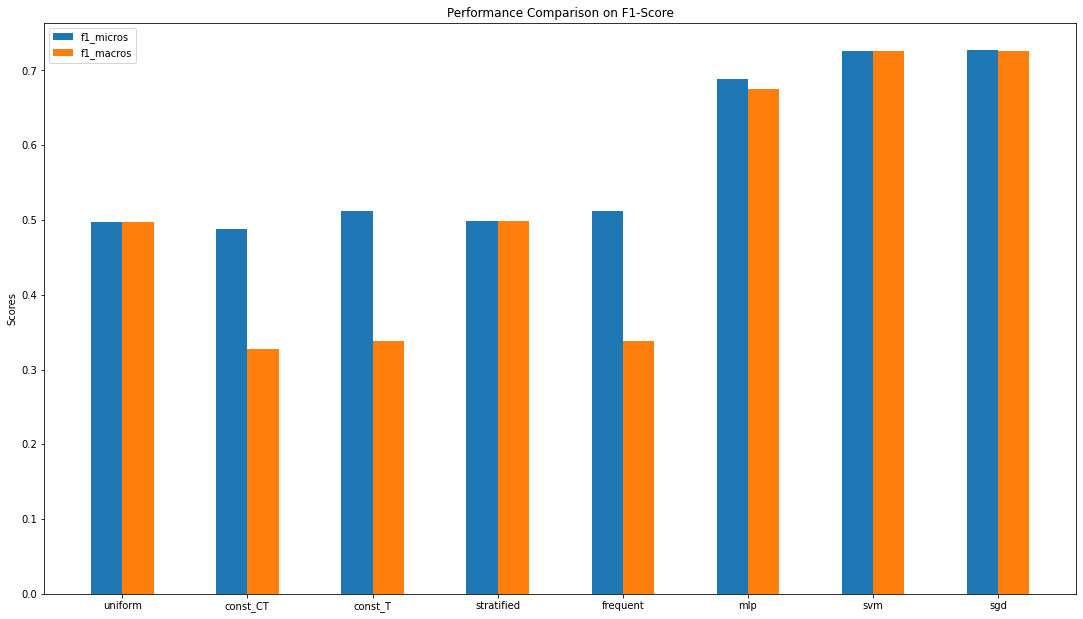

In [25]:
f1_macros, f1_micros, labels = [],[],[]
for clf in predictions:  
    f1_micros.append(f1_score(y_test,predictions[clf],average='micro'))
    f1_macros.append(f1_score(y_test,predictions[clf],average='macro'))
    labels.append(clf)

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, f1_micros, width, label='f1_micros')
rects2 = ax.bar(x + width/2, f1_macros, width, label='f1_macros')

fig.set_size_inches(18.5, 10.5)
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison on F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

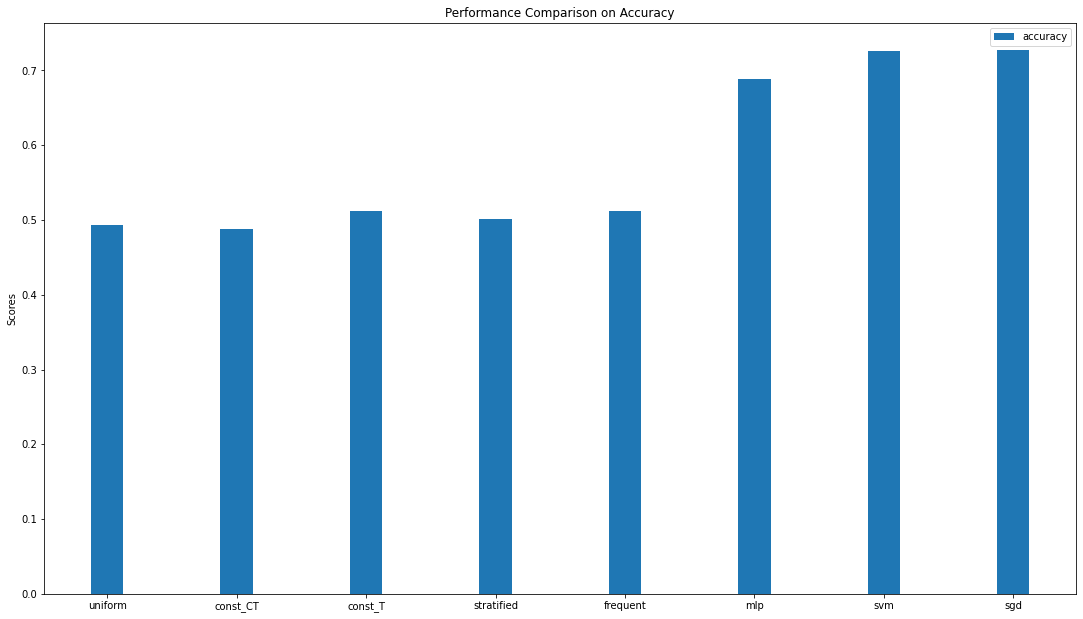

In [26]:
scores, acc_labels = [],[]
for clf in accuracies:  
    scores.append(accuracies[clf])
    acc_labels.append(clf)

x = np.arange(len(acc_labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x, scores, width, label='accuracy')

fig.set_size_inches(18.5, 10.5)
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison on Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(acc_labels)
ax.legend()

plt.show()

### Markdown Table

| Classifier | F1 Score (Micro) | F1 Score (Macro) | Accuracy| Cross Validation
|:----:|:------:|:-------:|:--------:|:--------:|
| **dc_uniform**       |         0.4982 |     0.4982     |0.5|-|
| **dc_const_CT**     |      0.4879 |    0.3279    |0.4879|-|
| **dc_const_T**       |        0.5121 |     0.3387     |0.5121|-|
| **dc_stratified**         |          0.4955 |      0.4954      | 0.4960|-|
| **dc_frequent**       |       0.5121 |    0.3387   |0.5121|-|
| **mlp**    |     0.7237 |    0.7129   |0.7238|0.7456|
| **svc**    |     0.7798 |    0.7625   |0.7798|0.7893|
| **sgd**    |     0.6431 |    0.6409   |0.6431|0.6516|

## Optimization

In [27]:
scaler = preprocessing.RobustScaler()
pca = decomposition.PCA()
selector = feature_selection.VarianceThreshold()
mlp = neural_network.MLPClassifier()
svm = SVC()
sgd = SGDClassifier()

In [28]:
X_train_copy = X_train
y_train_copy = y_train
X_test_copy  = X_test
y_test_copy  = y_test

X_train_sample, y_train_sample = shuffle(X_train, y_train, random_state=3)
X_train_sample = X_train_sample.to_numpy()[0:2000,:]
y_train_sample = y_train_sample.to_numpy()[0:2000]

In [29]:
fit_times, pred_times, new_predictions, new_accuracies = {}, {}, {}, {}

In [30]:
for strategy in predictions:
    new_predictions[strategy] = predictions[strategy]
for strategy in accuracies:
    new_accuracies[strategy] = accuracies[strategy]

### **MLP**

In [31]:
mlp_hidden_layers = [(i,2) for i in range(8,512,64)]
mlp_activation = ['logistic','identity','tanh','relu']    # ['logistic','identity','tanh','relu']
mlp_solver = ['lbfgs', 'sgd', 'adam']           # ['lbfgs', 'sgd', 'adam']
mlp_max_iter = np.arange(50,400,50)
mlp_learning_rate = ['constant', 'invscaling', 'adaptive'] # ['constant', 'invscaling', 'adaptive']
alpha = np.geomspace(1e-8,1e-3,5)
n_components = np.arange(5,11)

In [32]:
# pipe = Pipeline(steps=[('scaler', scaler), ('selector', selector), ('pca', pca), ('mlp', mlp)])
# mlp_estimator = model_selection.GridSearchCV(pipe, dict(pca__n_components = n_components,
#                                             mlp__hidden_layer_sizes=mlp_hidden_layers,
#                                             mlp__activation=mlp_activation,
#                                             mlp__solver=mlp_solver,
#                                             mlp__alpha=alpha,
#                                             mlp__learning_rate=mlp_learning_rate,
#                                             mlp__max_iter=mlp_max_iter), cv=5, scoring='f1_macro', n_jobs=-1,
#                                                                                                    verbose=1)
# mlp_estimator.fit(X_train_sample,y_train_sample)
# preds = mlp_estimator.predict(X_test)
# print("Best parameters",mlp_estimator.best_params_)

This took about 6 hours and produced 95000 out of the 304000 expected fits. We are trying another method.

In [33]:
mlp_solver = ['lbfgs', 'sgd', 'adam']
mlp_activation = ['logistic','identity','tanh','relu']
mlp_learning_rate = ['constant', 'invscaling', 'adaptive'] 
mlp_hidden_layer_sizes = [(100,100,100),(200,100)]

In [34]:
pipe = Pipeline(steps=[('mlp', mlp)])
ray_mlp_estimator = TuneGridSearchCV(pipe, dict(mlp__activation=mlp_activation,
                                            mlp__solver=mlp_solver,
                                            mlp__learning_rate=mlp_learning_rate,
                                               mlp__hidden_layer_sizes=mlp_hidden_layer_sizes), cv=5, scoring='f1_macro', n_jobs=-1,
                                                                                                   verbose=1)
ray_mlp_estimator.fit(X_train_sample,y_train_sample)
preds = ray_mlp_estimator.predict(X_test)
print("Best parameters with Ray",ray_mlp_estimator.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Best parameters with Ray {'mlp__activation': 'relu', 'mlp__solver': 'lbfgs', 'mlp__learning_rate': 'constant', 'mlp__hidden_layer_sizes': (100, 100, 100)}


Same methodology on the whole set.

In [35]:
mlp_solver = ['adam', 'lbfgs']
mlp_activation = ['logistic']
mlp_learning_rate = ['constant'] 
mlp_hidden_layer_sizes = [(100,100,100)]

In [36]:
pipe = Pipeline(steps=[('mlp', mlp)])
ray_mlp_estimator = TuneGridSearchCV(pipe, dict(mlp__activation=mlp_activation,
                                            mlp__solver=mlp_solver,
                                            mlp__learning_rate=mlp_learning_rate), cv=5, scoring='f1_macro', n_jobs=-1,
                                                                                                   verbose=1)
ray_mlp_estimator.fit(X_train, y_train)
preds = ray_mlp_estimator.predict(X_test)
print("Best parameters with Ray",ray_mlp_estimator.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Best parameters with Ray {'mlp__activation': 'logistic', 'mlp__solver': 'lbfgs', 'mlp__learning_rate': 'constant'}


Train:

In [37]:
X_train_copy = scaler.fit_transform(X_train)
X_test_copy = scaler.fit_transform(X_test)

mlp = neural_network.MLPClassifier(solver=ray_mlp_estimator.best_params_['mlp__solver'],
                    random_state=1,
                    activation=ray_mlp_estimator.best_params_['mlp__activation'],
                    learning_rate=ray_mlp_estimator.best_params_['mlp__learning_rate']) 

mlp.fit(X_train_copy,y_train_copy)
new_predictions['mlp'] = mlp.predict(X_test_copy)
new_accuracies['mlp'] = mlp.score(X_test_copy,y_test)


print(f'Confusion Matrices of the MLP Classifier:\n {confusion_matrix(y_test, new_predictions["mlp"])}')

print("\nAccuracy of the MLP Classifier:")
print(f'{new_accuracies["mlp"]}')

print("\nClassification Report of MLP:\n", classification_report(y_test,new_predictions['mlp']))

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Confusion Matrices of the MLP Classifier:
 [[9235 2710]
 [3206 9331]]

Accuracy of the MLP Classifier:
0.7583530757291072

Classification Report of MLP:
               precision    recall  f1-score   support

          CT       0.74      0.77      0.76     11945
           T       0.77      0.74      0.76     12537

    accuracy                           0.76     24482
   macro avg       0.76      0.76      0.76     24482
weighted avg       0.76      0.76      0.76     24482



### **SVC**

In [38]:
svm_kernel = ['linear', 'rbf', 'sigmoid']
svm_C = [1, 10, 100]
svm_tol = [1e-5, 1e-4, 1e-3]

In [39]:
pipe = Pipeline(steps=[('scaler', scaler), ('svm', svm)])
svm_estimator = TuneGridSearchCV(pipe, dict(
                                            svm__kernel=svm_kernel,
                                            svm__C=svm_C,
                                            svm__tol=svm_tol), cv=5, scoring='f1_macro', n_jobs=-1,
                                                                                                   verbose=1)
svm_estimator.fit(X_train_sample, y_train_sample)
preds = svm_estimator.predict(X_test)
print("Best parameters with Ray",svm_estimator.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Best parameters with Ray {'svm__kernel': 'linear', 'svm__C': 100, 'svm__tol': 1e-05}


Same methodology on the whole set. The running time is huge, therefore we commented out the code. 

In [40]:
svm_kernel = ['linear', 'rbf']
svm_C = [100]
svm_tol = [1e-5]

In [41]:
#########################################

# DISABLING THIS CODE BLOCK DUE TO LONG RUNNING TIME

######################################

# pipe = Pipeline(steps=[('scaler', scaler), ('svm', svm)])
# ray_svm_estimator = TuneGridSearchCV(pipe, dict(svm__kernel=svm_kernel,
#                                             svm__C=svm_C,
#                                             svm__tol=svm_tol), cv=5, scoring='f1_macro', n_jobs=-1,
#                                                                                                    verbose=1)
# ray_svm_estimator.fit(X_train,y_train)
# preds = ray_svm_estimator.predict(X_test)
# print("Best parameters with Ray",ray_svm_estimator.best_params_)

We stopped the cell because the SVC is insanely slow at large datasets. We will not train that classifier.

### **SGD**

In [42]:
sgd_loss = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
sgd_alpha = [1e-5,1e-4, 1e-3]
sgd_tol = [1e-5,1e-4, 1e-3]

In [43]:
pipe = Pipeline(steps=[('scaler', scaler), ('sgd', sgd)])
sgd_estimator = TuneGridSearchCV(pipe, dict(
                                            sgd__loss=sgd_loss,
                                            sgd__alpha=sgd_alpha,
                                            sgd__tol=sgd_tol), cv=5, scoring='f1_macro', n_jobs=-1,
                                                                                                   verbose=1)
sgd_estimator.fit(X_train_sample, y_train_sample)
preds = sgd_estimator.predict(X_test)
print("Best parameters with Ray",sgd_estimator.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Best parameters with Ray {'sgd__loss': 'log', 'sgd__alpha': 0.001, 'sgd__tol': 1e-05}


In [44]:
sgd_loss = ['hinge', 'log']
sgd_alpha = [1e-4, 1e-3]
sgd_tol = [1e-5]

In [45]:
pipe = Pipeline(steps=[('scaler', scaler), ('sgd', sgd)])
sgd_estimator = TuneGridSearchCV(pipe, dict(
                                            sgd__loss=sgd_loss,
                                            sgd__alpha=sgd_alpha,
                                            sgd__tol=sgd_tol), cv=5, scoring='f1_macro', n_jobs=-1,
                                                                                                   verbose=1)
sgd_estimator.fit(X_train, y_train)
preds = sgd_estimator.predict(X_test)
print("Best parameters with Ray",sgd_estimator.best_params_)

Best parameters with Ray {'sgd__loss': 'hinge', 'sgd__alpha': 0.001, 'sgd__tol': 1e-05}


In [46]:
X_train_copy = scaler.fit_transform(X_train)
X_test_copy = scaler.fit_transform(X_test)

sgd = SGDClassifier(loss=sgd_estimator.best_params_['sgd__loss'],
                    alpha=sgd_estimator.best_params_['sgd__alpha'],
                    tol=sgd_estimator.best_params_['sgd__tol'],
                    random_state=1) 

sgd.fit(X_train_copy,y_train_copy)
new_predictions['sgd'] = sgd.predict(X_test_copy)
new_accuracies['sgd'] = sgd.score(X_test_copy,y_test)


print(f'Confusion Matrices of the SGD Classifier:\n {confusion_matrix(y_test, new_predictions["sgd"])}')

print("\nAccuracy of the SGD Classifier:")
print(f'{new_accuracies["sgd"]}')

print("\nClassification Report of SGD:\n", classification_report(y_test,new_predictions['sgd']))

Confusion Matrices of the SGD Classifier:
 [[9624 2321]
 [3749 8788]]

Accuracy of the SGD Classifier:
0.7520627399722245

Classification Report of SGD:
               precision    recall  f1-score   support

          CT       0.72      0.81      0.76     11945
           T       0.79      0.70      0.74     12537

    accuracy                           0.75     24482
   macro avg       0.76      0.75      0.75     24482
weighted avg       0.76      0.75      0.75     24482



### Results

#### Markdown Table

| Classifier | F1 Score (Micro) | F1 Score (Macro) | Accuracy|
|:----:|:------:|:-------:|:--------:|
| **dc_uniform**       |         0.4982 |     0.4982     |0.5|
| **dc_const_CT**     |      0.4879 |    0.3279    |0.4879|
| **dc_const_T**       |        0.5121 |     0.3387     |0.5121|
| **dc_stratified**         |          0.4955 |      0.4954      | 0.4960|
| **dc_frequent**       |       0.5121 |    0.3387   |0.5121|
| **mlp**    |     0.7237 |    0.7129   |0.7238|
| **svc**    |     0.7798 |    0.7625   |0.7798|
| **sgd**    |     0.74 |    0.76   |0.75|

#### Bar Plots

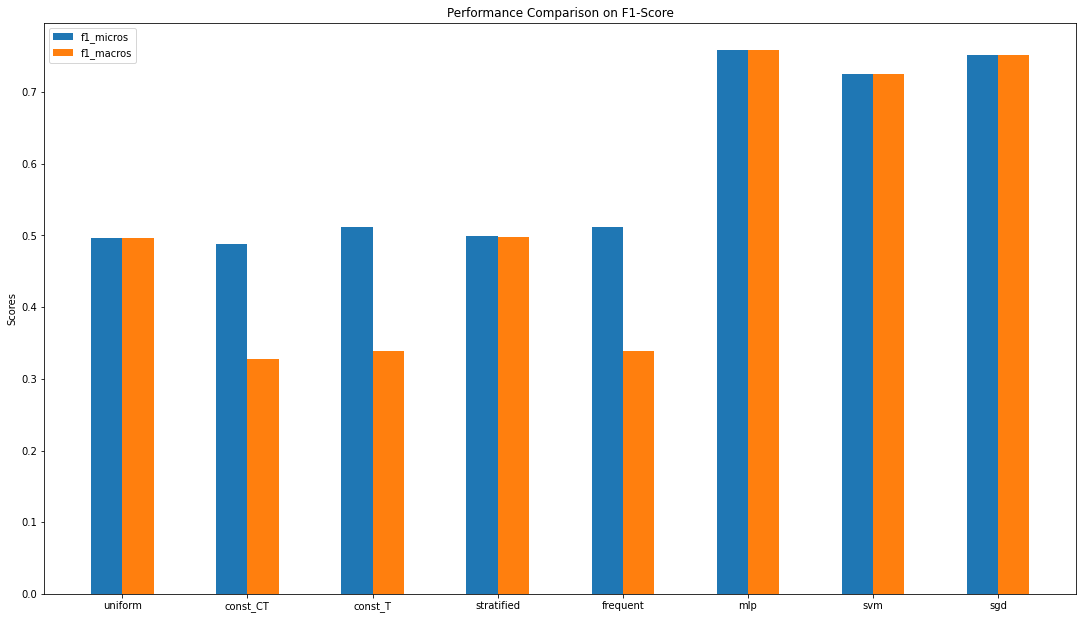

In [47]:
new_f1_macros, new_f1_micros, new_labels = [],[],[]
for clf in new_predictions:  
    new_f1_micros.append(f1_score(y_test,new_predictions[clf],average='micro'))
    new_f1_macros.append(f1_score(y_test,new_predictions[clf],average='macro'))
    new_labels.append(clf)

x = np.arange(len(new_labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, new_f1_micros, width, label='f1_micros')
rects2 = ax.bar(x + width/2, new_f1_macros, width, label='f1_macros')

fig.set_size_inches(18.5, 10.5)
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison on F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(new_labels)
ax.legend()

plt.show()

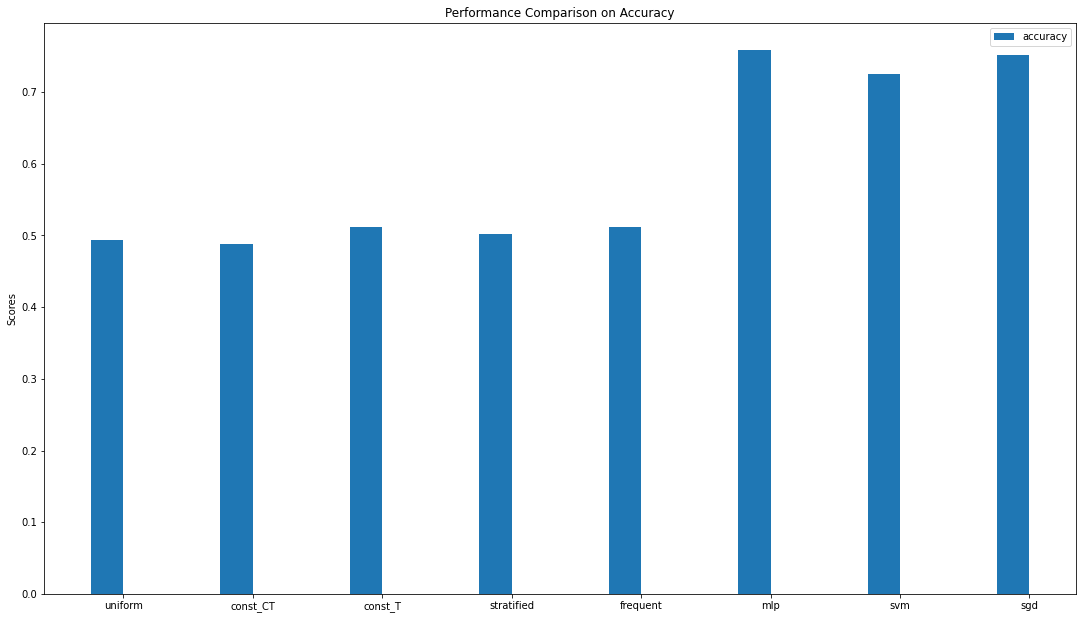

In [48]:
new_scores, new_acc_labels = [],[]
for clf in new_accuracies:  
    new_scores.append(new_accuracies[clf])
    new_acc_labels.append(clf)

x = np.arange(len(acc_labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, new_scores, width, label='accuracy')

fig.set_size_inches(18.5, 10.5)
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison on Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(new_acc_labels)
ax.legend()

plt.show()

We chose F1 score and accuracy, while also checking using 10-fold cross validation, because these are the best metrics for evaluating any dataset.
Having split the data into 80% train and 20% test set, we initially defined the classifiers in their raw form. This way, calling the .fit and .predict functions, we got their out-of-the-box scores and confusion matrices. We then defined a pipeline for each classifier, shuffled and got a slice of the training data and called GridSearchCV to get the hyperparameters on the sampled set. The problem that of course arose, is that the dataset is huge, therefore GridSearchCV takes a lot of hours to run. To counter this obstacle we used the Ray Library to optimize GridSearchCV using TuneGridSearchCV, which, down to its core, acts like a distributed GridSearchCV. After all that, we re-ran TuneGridSearchCV for each classifier, but this time on the training set; thus, we got the best hyperparameters, with which we trained our model and got its accuracy.
The best classifier is the MLP, followed by the SGD. The hyperparameters somewhat helped in the accuracy enhancement of each classifier. 